In [4]:
from linkedin_api import Linkedin
from selenium import webdriver
import time
import json
import pandas as pd
from pandas import datetime
import numpy as np
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.max_colwidth', None)

<ipython-input-4-b6a7ec156ed1>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18477\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18477\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\18477\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
wd = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - Downloading:  56%|█████▌    | 3.54M/6.30M [00:00<00:00, 6.03MB/s]

In [6]:
time.sleep(3)
linkedin_email = 'youremail@gmail.com'
linkedin_pw = 'gobears'
api = Linkedin(linkedin_email, linkedin_pw)

[WDM] - Downloading: 100%|██████████| 6.30M/6.30M [00:04<00:00, 1.34MB/s]


In [8]:
time.sleep(5)
jobs = api.search_jobs(
    keywords = 'data scientist',
    job_type = 'F',
    experience = '2|3|4',
    distance = 25,
    limit = -1,
    listed_at = 604800, #1week
    location_name = 'Boston, Massachusetts, United States'
)

In [9]:
job_list = []

#removed all remote jobs and data engineer jobs (my preference)
for i in range(len(jobs)):
    if (jobs[i]['workRemoteAllowed'] == False) & ('Data Engineer' not in jobs[i]['title']):
        a = jobs[i]['dashEntityUrn']
        ix = 0
        for ii in range(len(a)-1,0,-1):
            if a[ii] == ':':
                ix = ii+1
                break

        result = a[ix:]
        job_list.append(result)
        
df = pd.DataFrame({'job_id':job_list})
df.shape

(633, 1)

In [10]:
def get_job_desc(job_id,ix):
    time.sleep(3)
    print(ix)
    url = 'https://www.linkedin.com/jobs/view/' + job_id
    try:
        wd.get(url)
        desc = wd.find_element(By.CLASS_NAME,'show-more-less-html__markup').get_attribute('innerText')
        title = wd.find_element(By.CLASS_NAME,'topcard__title').get_attribute('innerText')
        company = wd.find_element(By.CLASS_NAME,'topcard__org-name-link').get_attribute('innerText').strip()
        return pd.Series([desc,title,company])
    except:
        return pd.Series(['','',''])

In [ ]:
job_meta = df.apply(lambda x: get_job_desc(x['job_id'],x.name), axis = 1)
job_meta.columns = ['desc_raw','title','company']
df = pd.concat([df,job_meta],axis=1)

In [13]:
ps = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(ps.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def preprocess_text(text):
    try:
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize words
        words = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Reconstruct the text
        preprocessed_text = ' '.join(words)

        # remove numbers
        preprocessed_text = ''.join([i for i in preprocessed_text if not i.isdigit()])

        preprocessed_text=stemSentence(preprocessed_text)

        return preprocessed_text
    except:
        return np.NaN

In [15]:
import docx2txt
resume_loc = r'C:\Users\18477\OneDrive\Desktop\Upwork\Jack S Mengel - Resume.docx'
text = docx2txt.process(resume_loc)

df = pd.concat(
    [
        df,
        pd.DataFrame({
            'job_id':[1],
            'desc_raw':text,
            'title':'fun guy',
            'company':'prestige worldwide'
        })
    ],
    axis=0
)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

df['desc'] = df['desc_raw'].apply(preprocess_text)
df.dropna(inplace=True)

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df['desc'])
bow_df = pd.DataFrame(bow.toarray(),columns=vectorizer.get_feature_names()).reset_index(drop = True)
df=df.reset_index(drop=True)
bow_df = bow_df.select_dtypes(exclude=['object'])
cols = bow_df.columns
bow_df['job_id'] = df['job_id']
bow_df['position_fill'] = df['title']
bow_df['company_fill'] = df['company']

df['job_id'] = df['job_id'].astype(float)
bow_df['job_id'] = bow_df['job_id'].astype(float)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [17]:
A = bow_df.loc[bow_df['job_id'] == 1,cols]
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(job_id):
    try:
        B = bow_df.loc[bow_df['job_id'] == job_id,cols]
        return cosine_similarity(A,B)[0][0]
    except:
        return 0

In [18]:
df['similarity'] = df.apply(lambda x: get_similarity(x['job_id']), axis = 1)
df['url'] = 'https://www.linkedin.com/jobs/view/' + df['job_id']

(array([ 29.,  82., 341., 118.,  57.,   6.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

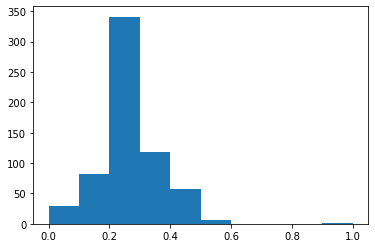

In [19]:
import matplotlib.pyplot as plt
plt.hist(df['similarity'])

In [20]:
#Write results to disc
df[['job_id','url','similarity','company','title']].sort_values(by='similarity',ascending=False).to_csv(r'C:\Users\18477\OneDrive\Desktop\LinkedIn\job_desc_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.csv', index = False)